# Actor-Critic

C:\Users\antha\AppData\Local\Temp\ipykernel_19776\2410441785.py:130: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Episode: 30 Total reward:  -1103.0 Running reward: -7260
Episode: 60 Total reward:  -2825.0 Running reward: -5390
Episode: 90 Total reward:  -4782.0 Running reward: -5748
Episode: 120 Total reward:  -2242.0 Running reward: -2718
Episode: 150 Total reward:  -3273.0 Running reward: -3045
Episode: 180 Total reward:  -2093.0 Running reward: -2142
Episode: 210 Total reward:  -1366.0 Running reward: -1251
Episode: 240 Total reward:  -767.0 Running reward: -1046
Episode: 270 Total reward:  -862.0 Running reward: -839
Episode: 300 Total reward:  -371.0 Running reward: -656
Episode: 330 Total reward:  -748.0 Running reward: -522
Episode: 360 Total reward:  -392.0 Running reward: -468
Episode: 390 Total reward:  -365.0 Running reward: -383
Episode: 420 Total reward:  -259.0 Running reward: -346
Episode: 450 Total reward:  -566.0 Running reward: -356
Episode: 480 Total reward:  -497.0 Running reward: -351
Episode: 510 Total reward:  -260.0 Running reward: -305
Episode: 540 Total reward:  -312.0 R

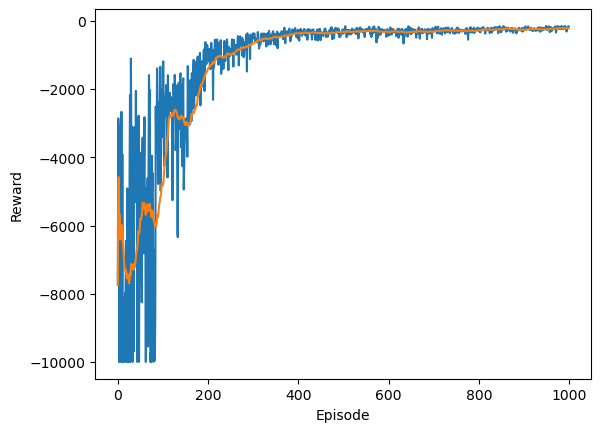

In [1]:
""" This Advantage Actor-Critic Algorithm (A2C) is implemented by Yinyu Jin.
Inspiered by https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py"""
import gym
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# avoid the warning message
gym.logger.set_level(40)

# hyperparameters
GAMMA = 0.99
learning_rate = 0.02
hidden_layer= 50  
episodes = 1000

env = gym.make('MountainCar-v0')
# env = env.unwrapped
# env.seed(0)
torch.manual_seed(1)

state_space = env.observation_space.shape[0]
action_space = env.action_space.n


SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])


class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_space, hidden_layer)

        # actor's layer
        self.action_fc2 = nn.Linear(hidden_layer, action_space)

        # critic's layer
        self.value_fc2 = nn.Linear(hidden_layer, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.fc1(x))

        # actor: choses action to take from state s_t by returning probability of each action
        action_prob = F.softmax(self.action_fc2(x), dim=-1)

        # critic: evaluates state value
        state_values = self.value_fc2(x)

        # return values for both actor and critic as a tupel of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values


model = Policy()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
eps = np.finfo(np.float32).eps.item()


def select_action(state):
    if isinstance(state, tuple):
            state = state[0]
    
    # 确保 state 是 NumPy 数组
    if not isinstance(state, np.ndarray):
        state = np.array([state]) if np.isscalar(state) else np.array(state)
    elif state.ndim == 1:
        state = state[np.newaxis, :]  # 添加批次维度，如果 state 是一个一维数组
    
    # 确保 state 是二维的，至少有两个元素
    assert state.shape[1] == 2, f"State shape should be (1, 2), but got {state.shape}"
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take 
    return action.item()


def update_policy():
    """
    Training code. Calcultes actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + GAMMA * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


all_rewards = []
running_rewards = []

for i_episode in range(1, episodes+1):

    # reset environment and episode reward
    state = env.reset(seed=1)
    ep_reward = 0

    # for each episode, only run 10000 steps so that we don't infinite loop while learning
    for t in range(10000):

        # select action from policy
        action = select_action(state)

        # take the action
        state, reward, done, _, info = env.step(action)

        model.rewards.append(reward)
        ep_reward += reward
        if done:
            break

    # update cumulative reward
    all_rewards.append(ep_reward)
    running_rewards.append(np.mean(all_rewards[-30:]))

    # perform backprop
    update_policy()

    # log results
    if i_episode % 30 == 0:
        print('Episode:', i_episode, 'Total reward: ', ep_reward, 'Running reward:', int(running_rewards[-1]))

plt.plot(all_rewards)
plt.plot(running_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()                

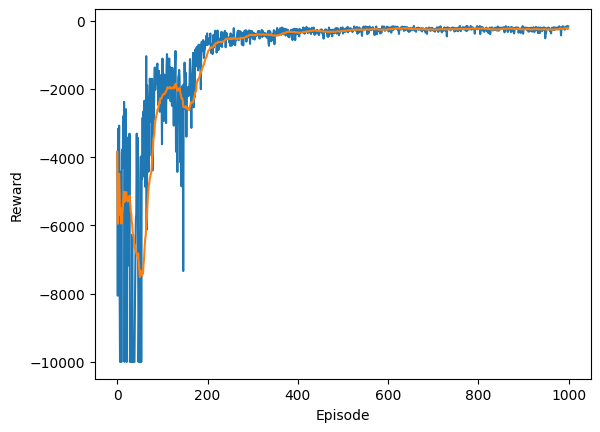

In [4]:
plt.plot(all_rewards)
plt.plot(running_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()  